In [44]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [74]:
def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [75]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_2/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_2/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float32)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[0][1]#/3.1415926
            Y = torch.tensor( Y, dtype=torch.float32 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y

In [76]:
all_ids = [str(i) for i in  list(np.arange(0,1000,1))]
train_ids = all_ids[:800]
val_ids   = all_ids[800:]
params = {
    'batch_size'  : 32,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

In [77]:
for batch in training_generator:
    break
batch[1].shape

torch.Size([32, 1])

tensor([0.0343])

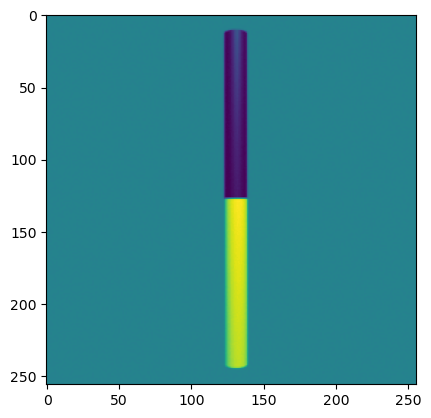

In [125]:
plt.imshow(batch[0][0][0])
batch[1][0]

tensor([0.6721])

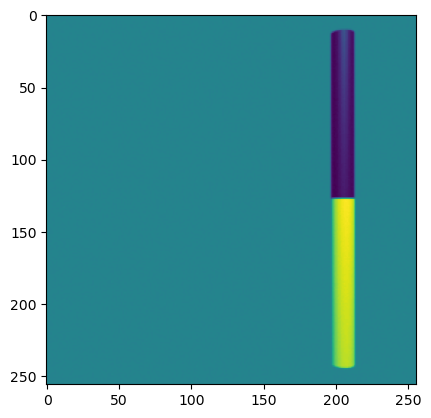

In [127]:
plt.imshow(batch[0][2][0])
batch[1][2]

In [145]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [152]:
model = Network()
no_of_params(model)

380111

In [39]:
class simple_cnn(nn.Module):
    def __init__(self):
        super(simple_cnn, self).__init__()
        self.conv1 = nn.Conv2d(1,4,kernel_size=4,padding=2,stride=2)
        self.conv2 = nn.Conv2d(4,8,kernel_size=4,padding=2,stride=2)
        self.conv3 = nn.Conv2d(8,16,kernel_size=4,padding=2,stride=2)
        self.conv4 = nn.Conv2d(16,32,kernel_size=4,padding=2,stride=2)
        #maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.activation = nn.Tanh()

        self.fc_1  = nn.Linear(9248,2048)
        self.fc_2  = nn.Linear(2048,1)
    
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = self.conv4(x)
        x = self.activation(x)
        x = torch.flatten(x,1)
        x = self.fc_1(x)
        x = self.activation(x)
        x = self.fc_2(x)
        x = self.activation(x)
        
        return x
model = simple_cnn()
no_of_params(model)

18954877

In [190]:
del model

In [191]:
from vit_pytorch import ViT
model = ViT(
        image_size  = 256,#256,
        channels    = 1,#1,
        patch_size  = 32, 
        num_classes = 1,
        dim         = 1024,
        depth       = 6,
        heads       = 16,
        mlp_dim     = 2048,
        dropout     = 0.1,
        emb_dropout = 0.1,
    )
no_of_params(model)

51505152

In [192]:
lr = 1e-7
wd = 1e-4
epochs = 200
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd
    )

gamma = 0.95
scheduler_step_size = 1
scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size = scheduler_step_size, 
    gamma     = gamma)

# scheduler = lr_scheduler.ExponentialLR(
#     optimizer, 
#     #step_size = scheduler_step_size, 
#     gamma     = gamma)

#scheduler.optimizer.param_groups[0]['lr']

In [193]:
train_losses = []
val_losses   = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", train_loss, " Val loss: ",val_loss)

EPOCH:  1  Train loss:  0.5330036461353302  Val loss:  0.4339311718940735
EPOCH:  2  Train loss:  0.41850462317466736  Val loss:  0.33054148299353464
EPOCH:  3  Train loss:  0.37224008202552794  Val loss:  0.31412518663065775
EPOCH:  4  Train loss:  0.36834142565727235  Val loss:  0.3462876336915152
EPOCH:  5  Train loss:  0.4351561164855957  Val loss:  0.4183672730411802
EPOCH:  6  Train loss:  0.4555798578262329  Val loss:  0.43721514088766916
EPOCH:  7  Train loss:  0.45083954215049743  Val loss:  0.40789909447942463
EPOCH:  8  Train loss:  0.41459363102912905  Val loss:  0.3433858986411776
EPOCH:  9  Train loss:  0.3469154179096222  Val loss:  0.27108914085796904
EPOCH:  10  Train loss:  0.3185223084688187  Val loss:  0.2880643052714212
EPOCH:  11  Train loss:  0.33135259747505186  Val loss:  0.29174548600401196
EPOCH:  12  Train loss:  0.35956930458545683  Val loss:  0.3181464107973235
EPOCH:  13  Train loss:  0.37397482693195344  Val loss:  0.3864175890173231
EPOCH:  14  Train lo

EPOCH:  109  Train loss:  0.20366359531879424  Val loss:  0.1702673669372286
EPOCH:  110  Train loss:  0.21351016104221343  Val loss:  0.14899467357567378
EPOCH:  111  Train loss:  0.2053927445411682  Val loss:  0.1627445848924773
EPOCH:  112  Train loss:  0.20263779103755952  Val loss:  0.15641785200153077
EPOCH:  113  Train loss:  0.19876462280750273  Val loss:  0.15030033460685185
EPOCH:  114  Train loss:  0.1979237073659897  Val loss:  0.17636762772287642
EPOCH:  115  Train loss:  0.194818959236145  Val loss:  0.15272473863192967
EPOCH:  116  Train loss:  0.20111902594566344  Val loss:  0.1499701983162335
EPOCH:  117  Train loss:  0.20166299283504485  Val loss:  0.14719029675636972
EPOCH:  118  Train loss:  0.22080493867397308  Val loss:  0.15905436660562242
EPOCH:  119  Train loss:  0.20839558362960817  Val loss:  0.15205960827214376
EPOCH:  120  Train loss:  0.2057702824473381  Val loss:  0.15455451820577895
EPOCH:  121  Train loss:  0.1999679070711136  Val loss:  0.1537366850035

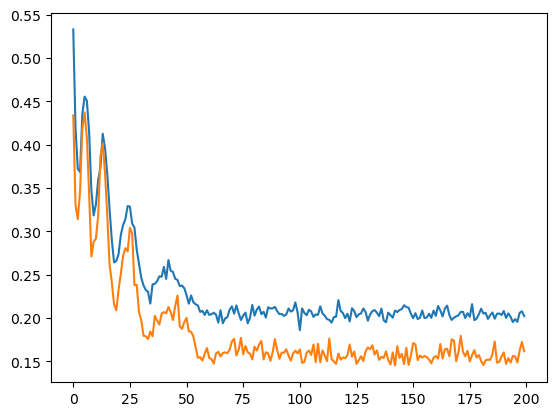

In [194]:
plt.plot(train_losses)
plt.plot(val_losses)

In [180]:
for batch in validation_generator:
    break
output = model(batch[0])
output

tensor([[ 0.0638],
        [-0.1058],
        [ 0.0247],
        [-0.1587],
        [-0.0200],
        [ 0.1193],
        [ 0.0832],
        [ 0.1025],
        [-0.1003],
        [ 0.0785],
        [ 0.0999],
        [ 0.0710],
        [ 0.2083],
        [-0.1122],
        [-0.0098],
        [-0.0417],
        [-0.1493],
        [-0.0013],
        [-0.0999],
        [ 0.1952],
        [-0.0462],
        [ 0.0181],
        [-0.0209],
        [-0.1080],
        [ 0.0747],
        [ 0.0586],
        [-0.1095],
        [ 0.2024],
        [-0.0959],
        [-0.1235],
        [-0.0359],
        [-0.1703]], grad_fn=<AddmmBackward0>)

In [181]:
batch[1]

tensor([[ 0.3644],
        [-0.7305],
        [ 0.1100],
        [-0.8507],
        [-0.1759],
        [ 0.6511],
        [ 0.9832],
        [ 0.9195],
        [-0.6705],
        [ 0.9973],
        [ 0.9715],
        [ 0.3036],
        [ 0.8709],
        [-0.6517],
        [ 0.0593],
        [-0.0764],
        [-0.8698],
        [-0.0366],
        [-0.7005],
        [ 0.5088],
        [-0.9773],
        [ 0.1548],
        [-0.0169],
        [-0.6576],
        [ 0.3296],
        [ 0.4350],
        [-0.7363],
        [ 0.8288],
        [-0.3906],
        [-0.2690],
        [-0.0730],
        [-0.7950]])

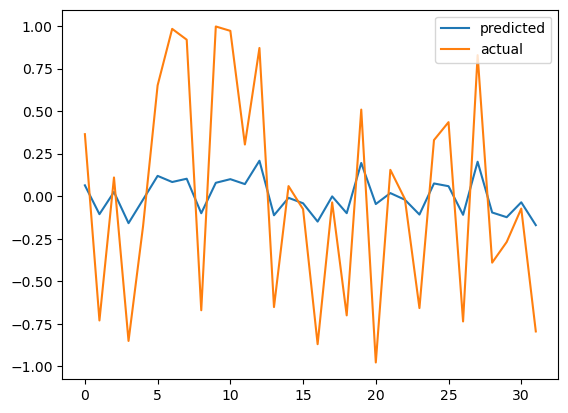

In [182]:
plt.plot(output.detach().numpy(),label="predicted")
plt.plot(batch[1].detach().numpy(),label="actual")
plt.legend()

(tensor([-0.4340], grad_fn=<SelectBackward0>), tensor([-0.4172]))

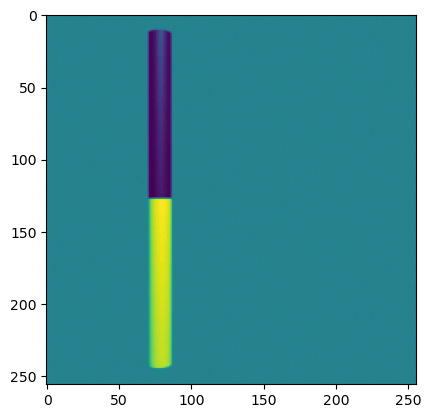

In [170]:
i = 19
plt.imshow( batch[0][i][0] ) 
model(batch[0])[i], batch[1][i]

In [104]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(3)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*122*122, 1)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output)))     
        output = output.view(-1, 24*122*122)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output

In [106]:
model = Network()

In [107]:
model(batch[0])

tensor([[-0.0769],
        [-0.3395],
        [-0.1337],
        [-0.2621],
        [-0.1860],
        [-0.3517],
        [ 0.1420],
        [ 0.1395],
        [-0.3233],
        [-0.1567],
        [-0.0434],
        [ 0.0372],
        [-0.0105],
        [-0.0468],
        [-0.2757],
        [-0.1481],
        [-0.1247],
        [-0.5078],
        [-0.0054],
        [ 0.1468],
        [ 0.1083],
        [-0.4653],
        [-0.4806],
        [-0.5038],
        [-0.1135],
        [-0.1031],
        [-0.0951],
        [ 0.2366],
        [ 0.0165],
        [ 0.2053],
        [-0.2012],
        [-0.0967]], grad_fn=<TanhBackward0>)

In [91]:
no_of_params(model)

380111

Network(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=357216, out_features=1, bias=True)
)